In [1]:
%reload_ext autoreload
%autoreload 2


import functools
print = functools.partial(print, flush=True)

import os
import numpy as np
import pandas as pd
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42 # for pdfs
import matplotlib.pyplot as plt
from matplotlib import cm
from pathlib import Path
import pickle
from tqdm import tqdm
import scipy

import flexiznam as flz
from cottage_analysis.analysis import spheres, common_utils, find_depth_neurons, fit_gaussian_blob
from cottage_analysis.plotting import basic_vis_plots
from cottage_analysis.pipelines import pipeline_utils
from v1_depth_analysis.v1_manuscript_2023 import depth_selectivity, get_session_list
from v1_depth_analysis.v1_manuscript_2023 import common_utils as plt_common_utils

In [2]:
# Load data
# Load an example session
project='hey2_3d-vision_foodres_20220101'
session_name='PZAH10.2f_S20230703'
flexilims_session = flz.get_flexilims_session(project)

# vs_df, trials_df = spheres.sync_all_recordings(
#     session_name=session_name,
#     flexilims_session=flexilims_session,
#     project=project,
#     filter_datasets={'anatomical_only':3},
#     recording_type="two_photon",
#     protocol_base="SpheresPermTubeReward",
#     photodiode_protocol=2,
#     return_volumes=True,
# )

neurons_ds = pipeline_utils.create_neurons_ds(
    session_name=session_name, flexilims_session=flexilims_session, project=None, conflicts="skip"
)
neurons_df = pd.read_pickle(neurons_ds.path_full)

In [3]:
neurons_df.head()

,roi,is_depth_neuron,depth_neuron_anova_p,best_depth,preferred_depth_closedloop,depth_tuning_popt_closedloop,depth_tuning_trials_closedloop,preferred_depth_closedloop_crossval,depth_tuning_popt_closedloop_crossval,depth_tuning_trials_closedloop_crossval,...,preferred_RS_closedloop_g2d,preferred_OF_closedloop_g2d,rsof_popt_closedloop_g2d,rsof_rsq_closedloop_g2d,rsof_test_rsq_closedloop_crossval_g2d,rsof_test_spearmanr_rval_closedloop_crossval_g2d,rsof_test_spearmanr_pval_closedloop_crossval_g2d,rsof_test_rsq_closedloop_gadd,rsof_test_spearmanr_rval_closedloop_gadd,rsof_test_spearmanr_pval_closedloop_gadd
0,0,False,0.42482,1.6,2.056876,"[0.30334835470624505, 0.7211884178825624, 1.08...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",2.624309,"[0.1940608249451621, 0.9648175364858693, 1.064...","[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]",...,4.994525,0.009744,"[1.2192949271889575, 1.6083422133212943, -0.58...",0.000554,-0.000984,0.000589,9.455907e-01,0.000266,0.018345,1.955380e-03
1,1,False,0.060926,6.4,20.000000,"[1.3832461133734515, 2.9957322735539904, 0.250...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.738095,"[1.4837056518487741, -0.3036829328755414, 1.12...","[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]",...,3.963462,0.410817,"[2.3450962741662096, 1.3771179874363653, 3.158...",0.004446,0.002921,0.046569,6.650211e-08,0.005704,0.070113,2.159071e-32
2,2,False,0.415554,6.4,20.000000,"[0.2970181637455472, 2.9957322735539904, 0.585...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",20.000000,"[0.46621947908777245, 2.9957322735539904, 0.57...","[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]",...,5.000000,52.359878,"[2.832660197575149, 1.6094379124340712, 8.0063...",0.001037,-0.000351,-0.016648,5.365189e-02,0.000600,0.012217,3.917283e-02
3,3,False,0.078913,0.4,0.774730,"[0.8237850063367207, -0.25524099848893256, 0.5...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",0.630586,"[3.0204672706067366, -0.46110544763824973, 1.0...","[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]",...,0.057471,1.550543,"[3.783193194744668, -2.856481375954265, 4.4868...",0.022951,0.026758,0.153300,1.890162e-71,0.023195,0.132818,2.671563e-112
4,4,True,0.006352,6.4,8.070370,"[0.4081182085945314, 2.0881993908171084, 0.728...","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",18.482979,"[1.6091355756541077, 2.9168502694001637, 0.800...","[0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22]",...,2.872335,0.001219,"[-0.4522320327418951, 1.055125308099145, -2.66...",0.003404,0.001283,0.040476,2.690101e-06,0.003141,0.052057,1.454057e-18


In [8]:
neurons_df.isna().any()

roi                                                 False
is_depth_neuron                                     False
depth_neuron_anova_p                                False
best_depth                                          False
preferred_depth_closedloop                          False
depth_tuning_popt_closedloop                        False
depth_tuning_trials_closedloop                      False
preferred_depth_closedloop_crossval                 False
depth_tuning_popt_closedloop_crossval               False
depth_tuning_trials_closedloop_crossval             False
depth_tuning_test_rsq_closedloop                    False
depth_tuning_test_spearmanr_rval_closedloop         False
depth_tuning_test_spearmanr_pval_closedloop         False
rf_coef_closedloop                                  False
rf_rsq_closedloop                                   False
rf_coef_ipsi_closedloop                             False
rf_rsq_ipsi_closedloop                              False
rf_reg_xy_clos

In [10]:
neurons_df[neurons_df['depth_tuning_test_spearmanr_pval_closedloop'] < 0.05][:10].columns

Index(['roi', 'is_depth_neuron', 'depth_neuron_anova_p', 'best_depth',
       'preferred_depth_closedloop', 'depth_tuning_popt_closedloop',
       'depth_tuning_trials_closedloop', 'preferred_depth_closedloop_crossval',
       'depth_tuning_popt_closedloop_crossval',
       'depth_tuning_trials_closedloop_crossval',
       'depth_tuning_test_rsq_closedloop',
       'depth_tuning_test_spearmanr_rval_closedloop',
       'depth_tuning_test_spearmanr_pval_closedloop', 'rf_coef', 'rf_rsq',
       'rf_coef_ipsi', 'rf_rsq_ipsi', 'rf_reg_xy', 'rf_reg_depth',
       'preferred_RS_closedloop_crossval_g2d',
       'preferred_OF_closedloop_crossval_g2d',
       'rsof_popt_closedloop_crossval_g2d', 'rsof_rsq_closedloop_crossval_g2d',
       'preferred_RS_openloop_actual_crossval_g2d',
       'preferred_OF_openloop_actual_crossval_g2d',
       'rsof_popt_openloop_actual_crossval_g2d',
       'rsof_rsq_openloop_actual_crossval_g2d',
       'preferred_RS_openloop_virtual_crossval_g2d',
       'preferr

In [3]:
os.listdir(neurons_ds.path_full.parent)

['fit_rs_of_tuning_gaussian_2d_crossval_k1.pickle',
 'fit_rs_of_tuning_gaussian_additive.pickle',
 'R183410_SpheresPermTubeReward',
 'suite2p_rois_1',
 'fit_rs_of_tuning_gaussian_additive_k1.pickle',
 'SpheresPermTubeRewardPlayback',
 'fit_rs_of_tuning_gaussian_OF_k1.pickle',
 'neurons_df.pickle',
 'SpheresPermTubeReward',
 'fit_rs_of_tuning_gaussian_2d_crossval.pickle',
 'suite2p_rois_0',
 'fit_rs_of_tuning_gaussian_2d.pickle',
 'fit_rs_of_tuning_gaussian_2d_k5.pickle',
 'fit_rs_of_tuning_gaussian_OF.pickle',
 'R202510_SpheresPermTubeRewardPlayback',
 'fit_rs_of_tuning_gaussian_2d_k1.pickle',
 'plots']

In [14]:
neurons_df_g2d = pd.read_pickle(neurons_ds.path_full.parent/'fit_rs_of_tuning_gaussian_2d_k1.pickle')
neurons_df_g2d_crossval = pd.read_pickle(neurons_ds.path_full.parent/'fit_rs_of_tuning_gaussian_2d_k5.pickle')
neurons_df_g2d["rsof_rsq_closedloop_g2d"], neurons_df_g2d_crossval["rsof_test_rsq_closedloop_g2d"]

(0      0.008646
 1      0.033564
 2      0.060674
 3      0.016862
 4      0.012818
          ...   
 660    0.000347
 661    0.005314
 662    0.000442
 663    0.007966
 664    0.000325
 Name: rsof_rsq_closedloop_g2d, Length: 665, dtype: float64,
 0      0.007204
 1      0.019751
 2      0.054832
 3      0.016631
 4      0.012613
          ...   
 660   -0.000510
 661    0.003687
 662   -0.000036
 663    0.007732
 664   -0.000176
 Name: rsof_test_rsq_closedloop_g2d, Length: 665, dtype: float64)

In [15]:
neurons_df_g2d_crossval

,roi,preferred_RS_closedloop_g2d,preferred_OF_closedloop_g2d,rsof_popt_closedloop_g2d,rsof_rsq_closedloop_g2d,rsof_test_rsq_closedloop_g2d,rsof_test_spearmanr_rval_closedloop_g2d,rsof_test_spearmanr_pval_closedloop_g2d
0,0,NaN,NaN,[nan],NaN,0.007204,0.045650,8.330617e-17
1,1,NaN,NaN,[nan],NaN,0.019751,0.081685,2.582090e-50
2,2,NaN,NaN,[nan],NaN,0.054832,0.252553,0.000000e+00
3,3,NaN,NaN,[nan],NaN,0.016631,0.135620,3.419158e-136
4,4,NaN,NaN,[nan],NaN,0.012613,0.115601,3.038446e-99
...,...,...,...,...,...,...,...,...
660,660,NaN,NaN,[nan],NaN,-0.000510,-0.001705,7.559339e-01
661,661,NaN,NaN,[nan],NaN,0.003687,0.048603,7.603614e-19
662,662,NaN,NaN,[nan],NaN,-0.000036,0.008381,1.265289e-01
663,663,NaN,NaN,[nan],NaN,0.007732,0.076732,1.368666e-44


(array([  1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   1.,   1.,   7., 619.,  29.,
          3.,   2.,   0.,   0.,   0.,   2.]),
 array([-0.08054334, -0.07864142, -0.07673949, -0.07483757, -0.07293565,
        -0.07103372, -0.0691318 , -0.06722988, -0.06532796, -0.06342603,
        -0.06152411, -0.05962219, -0.05772026, -0.05581834, -0.05391642,
        -0.0520145 , -0.05011257, -0.04821065, -0.04630873, -0.0444068 ,
        -0.04250488, -0.04060296, -0.03870103, -0.03679911, -0.03489719,
        -0.03299527, -0.03109334, -0.02919142, -0.0272895 , -0.02538757,
        -0.02348565, -0.02158373, -0.0196818 , -0.01777988, -0.01587796,
        -0.01397604, -0.01207411, -0.01017219, -0.00827027, -0.00636834,
        -0.00446642, -0.0025645 , -0.00066258,  0.00123935,  0.00314127,
 

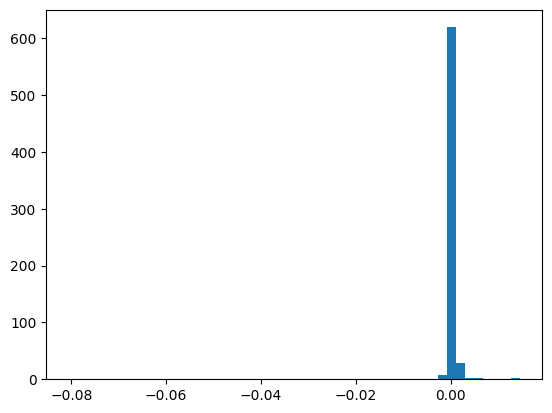

In [13]:
plt.hist(neurons_df_g2d["rsof_rsq_closedloop_g2d"] - neurons_df_g2d_crossval["rsof_test_rsq_closedloop_g2d"], bins=50)

In [8]:
neurons_df_g2d_crossval["rsof_test_rsq_closedloop_g2d"]

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
       ..
660   NaN
661   NaN
662   NaN
663   NaN
664   NaN
Name: preferred_RS_closedloop_g2d, Length: 665, dtype: float64

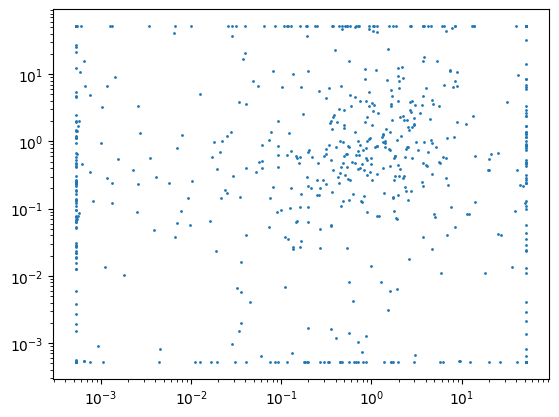

In [19]:
plt.scatter(neurons_df["preferred_OF_closedloop_g2d"], neurons_df["preferred_OF_openloop_actual_g2d"], s=1)
plt.xscale("log")
plt.yscale("log")

In [15]:
neurons_df.columns

Index(['roi', 'is_depth_neuron', 'depth_neuron_anova_p', 'best_depth',
       'preferred_depth_closedloop', 'depth_tuning_popt_closedloop',
       'depth_tuning_trials_closedloop', 'preferred_depth_closedloop_crossval',
       'depth_tuning_popt_closedloop_crossval',
       'depth_tuning_trials_closedloop_crossval',
       'depth_tuning_test_rsq_closedloop',
       'depth_tuning_test_spearmanr_rval_closedloop',
       'depth_tuning_test_spearmanr_pval_closedloop', 'rf_coef', 'rf_rsq',
       'rf_coef_ipsi', 'rf_rsq_ipsi', 'preferred_RS_closedloop_gadd',
       'preferred_OF_closedloop_gadd', 'rsof_popt_closedloop_gadd',
       'rsof_rsq_closedloop_gadd', 'preferred_RS_openloop_actual_gadd',
       'preferred_OF_openloop_actual_gadd', 'rsof_popt_openloop_actual_gadd',
       'rsof_rsq_openloop_actual_gadd', 'preferred_RS_openloop_virtual_gadd',
       'preferred_OF_openloop_virtual_gadd', 'rsof_popt_openloop_virtual_gadd',
       'rsof_rsq_openloop_virtual_gadd',
       'preferred_RS_cl

In [29]:
depth_list = find_depth_neurons.find_depth_list(trials_df)
log_depth_list = np.log(depth_list)
log_depth_list = np.append(
    log_depth_list, (log_depth_list[-1] + log_depth_list[1] - log_depth_list[0])
)
log_depth_list = np.insert(
    log_depth_list, 0, (log_depth_list[0] - log_depth_list[1] + log_depth_list[0])
)
depth_list_expand = np.exp(log_depth_list)
bins = (depth_list_expand[1:] + depth_list_expand[:-1]) / 2
trials_df["depth_label"] = pd.cut(trials_df["depth"], bins=bins, labels=np.arange(len(depth_list)))
trials_df["depth_label"] = [[x]*len(y) for x, y in zip(trials_df["depth_label"], trials_df["RS_stim"]) ]
dff = np.concatenate(trials_df[trials_df.closed_loop==1]["dff_stim"].values, axis=0)


73888

In [6]:
fit_gaussian_blob.fit_rs_of_tuning(
    trials_df=trials_df,
    model="gaussian_OF",
    choose_trials=None,
    closedloop_only=False,
    rs_thr=0.01,
    param_range={"rs_min": 0.005, "rs_max": 5, "of_min": 0.03, "of_max": 3000},
    niter=1,
    min_sigma=0.25,
    k_folds=2,
)

Process protocol 1/2...
Fitting closedloop running...
Fit with cross-validation...


/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/analysis/fit_gaussian_blob.py:502: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_df_fit["depth_label"] = pd.cut(trials_df_fit["depth"], bins=bins, labels=np.arange(len(depth_list)))
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/analysis/fit_gaussian_blob.py:503: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_df_fit["depth_label"] = [[x]*len(y) for x, y in zip(trials_df_fit["depth_label"

KeyboardInterrupt: 

  0%|          | 0/67 [00:00<?, ?it/s]/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/analysis/find_depth_neurons.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_df["trial_mean_dff"] = trials_df.apply(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/analysis/find_depth_neurons.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_df["trial_mean_dff"] = trials_df.apply(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/c

KeyboardInterrupt: 

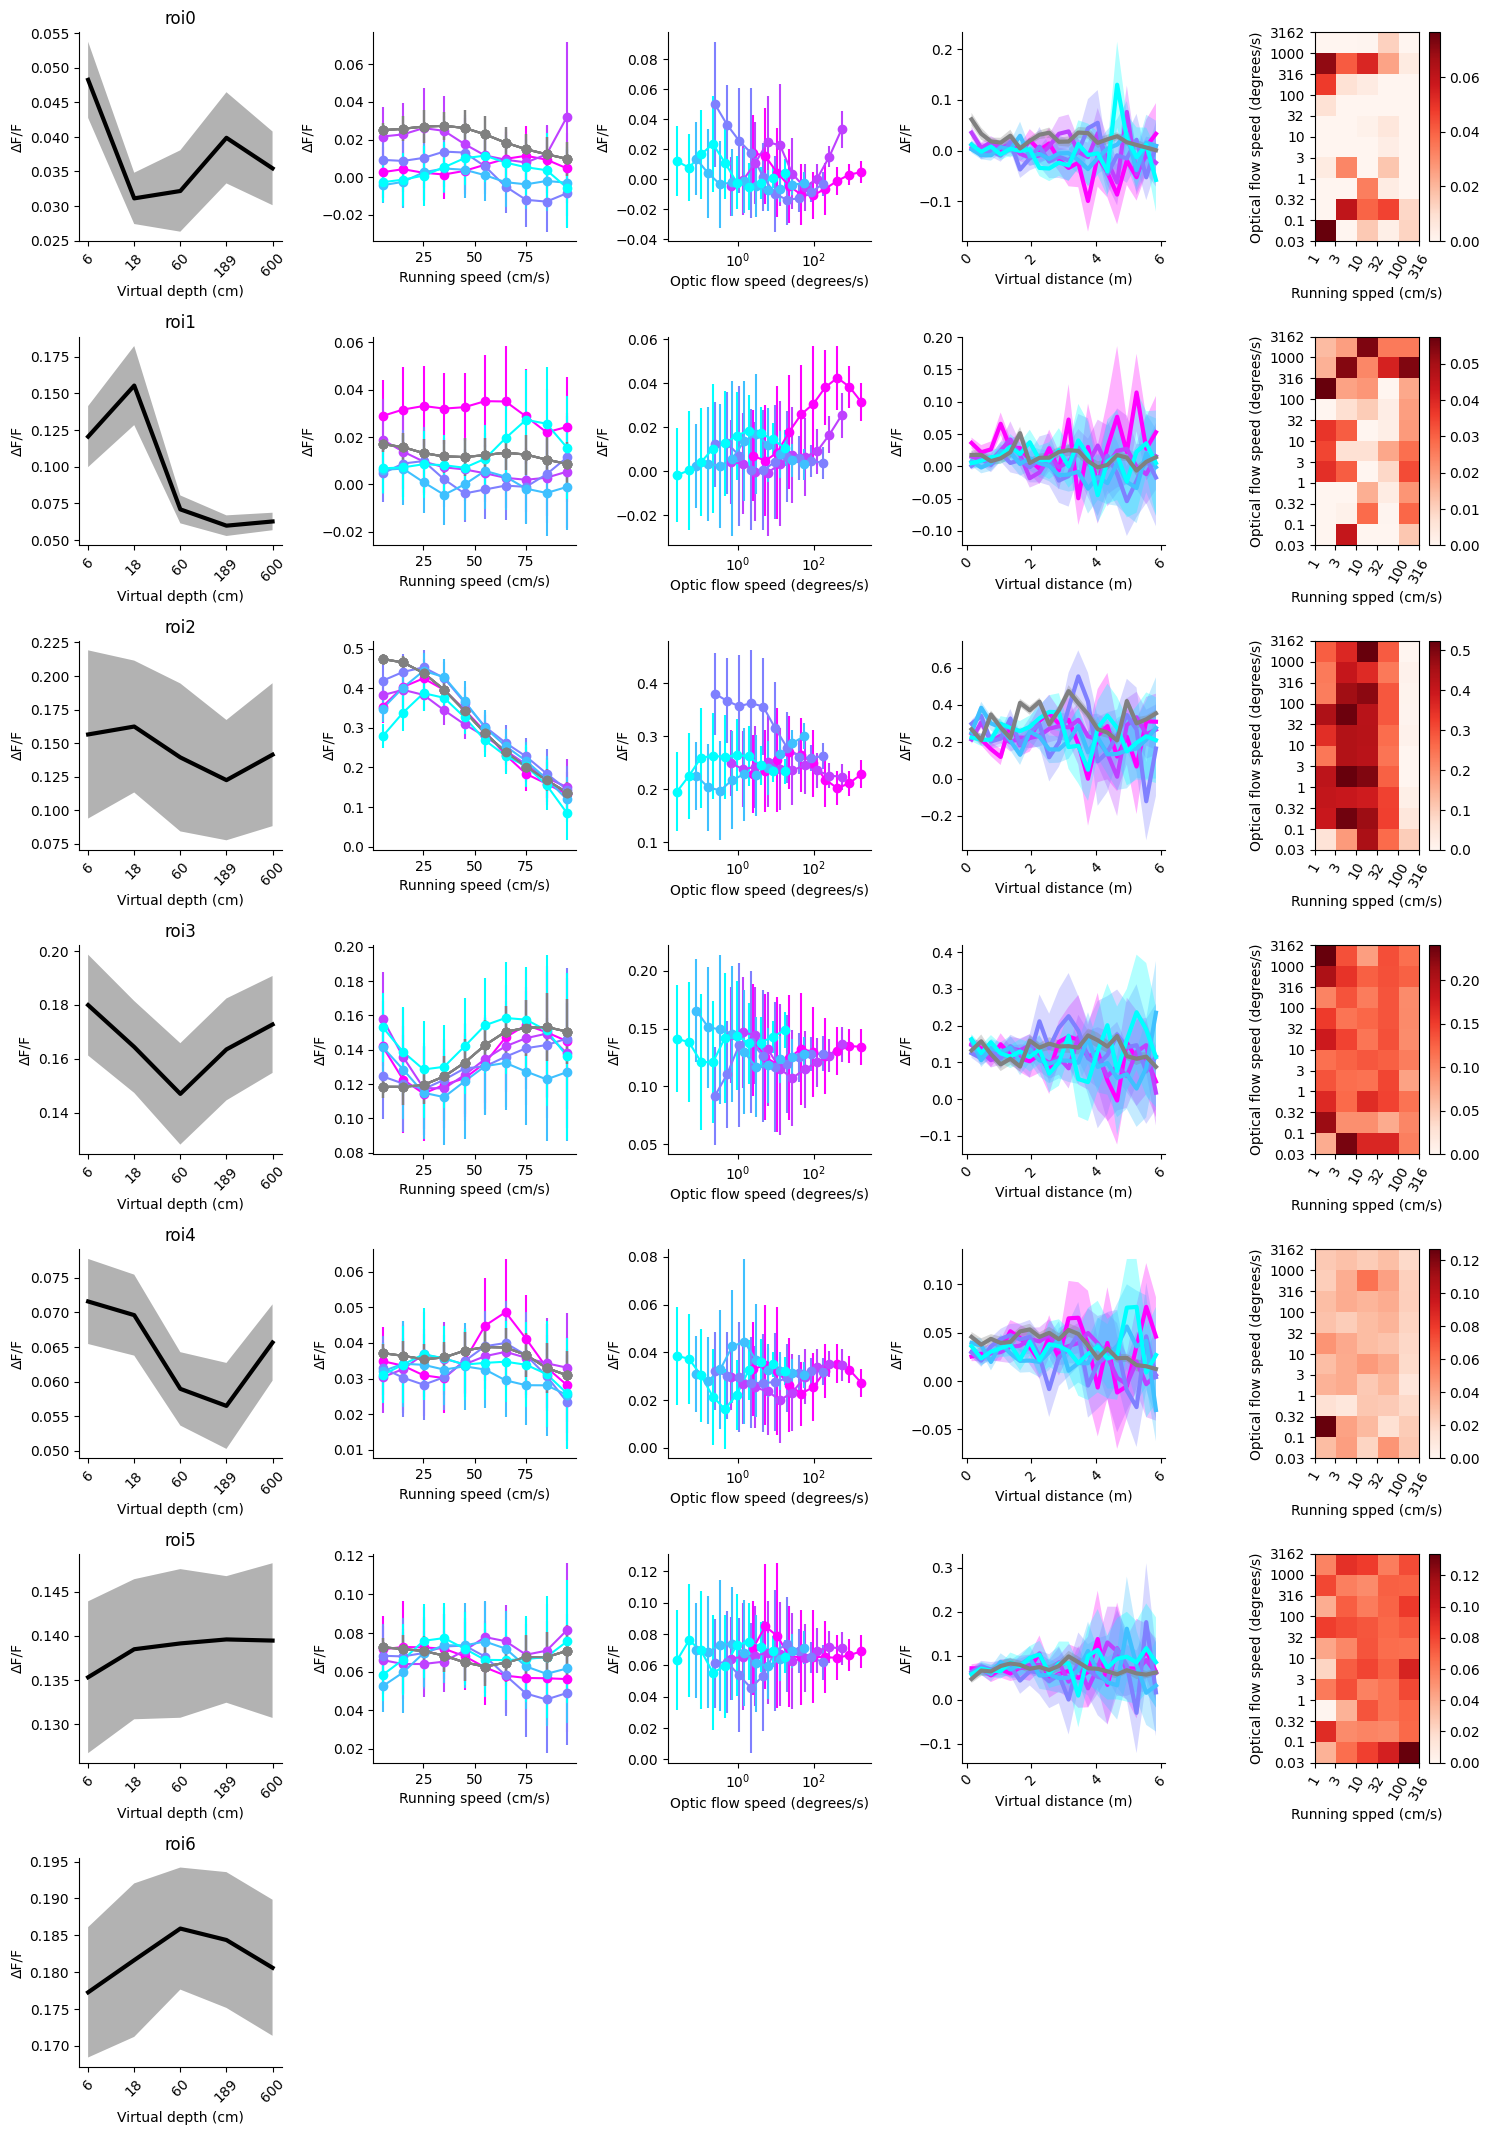

In [11]:
from cottage_analysis.plotting import basic_vis_plots
kwargs = {
        "RS_OF_matrix_log_range": {
                    "rs_bin_log_min": 0,
                    "rs_bin_log_max": 2.5,
                    "rs_bin_num": 6,
                    "of_bin_log_min": -1.5,
                    "of_bin_log_max": 3.5,
                    "of_bin_num": 11,
                    "log_base": 10,
                }
    }
basic_vis_plots.basic_vis_session(neurons_df, trials_df, neurons_ds, **kwargs)

In [ ]:
plot_depth_tuning_curve(
    neurons_df=neurons_df,
    trials_df=trials_df[trials_df.closed_loop == is_closedloop],
    roi=roi,
    rs_thr=params["rs_thr"],
    plot_fit=False,
    linewidth=3,
    linecolor="k",
    fit_linecolor="r",
    closed_loop=1,
)

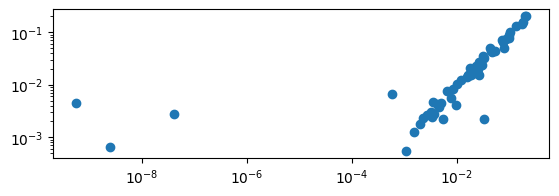

In [27]:
select = (neurons_df.depth_tuning_test_rsq_closedloop > 0.04 )
plt.scatter(neurons_df[select]["rsof_rsq_closedloop_g2d"], neurons_df[select]["rsof_rsq_closedloop_gadd"])
plt.xscale("log")
plt.yscale("log")
plt.gca().set_aspect('equal')

# CHANGE THIS TO CROSS-VALIDATED 

(array([ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  2.,  0.,
         0.,  0.,  2.,  2.,  5., 25., 10.,  6.,  2.,  5.,  0.,  0.,  0.,
         1.,  0.,  0.,  4.]),
 array([-0.04864628, -0.0459791 , -0.04331193, -0.04064475, -0.03797757,
        -0.0353104 , -0.03264322, -0.02997604, -0.02730887, -0.02464169,
        -0.02197451, -0.01930734, -0.01664016, -0.01397298, -0.01130581,
        -0.00863863, -0.00597145, -0.00330428, -0.0006371 ,  0.00203008,
         0.00469725,  0.00736443,  0.01003161,  0.01269878,  0.01536596,
         0.01803314,  0.02070031,  0.02336749,  0.02603467,  0.02870184,
         0.03136902]),
 <BarContainer object of 30 artists>)

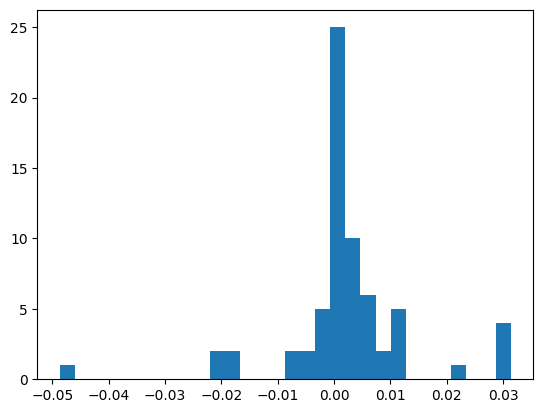

In [28]:
plt.hist(neurons_df[select]["rsof_rsq_closedloop_g2d"] - neurons_df[select]["rsof_rsq_closedloop_gadd"], bins=30)

In [30]:
from scipy.stats import wilcoxon
_, p = wilcoxon(neurons_df[select]["rsof_rsq_closedloop_g2d"], neurons_df[select]["rsof_rsq_closedloop_gadd"])
p


0.0013824871203173585

/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/analysis/find_depth_neurons.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_df["trial_mean_dff"] = trials_df.apply(
/nemo/lab/znamenskiyp/home/users/hey2/codes/cottage_analysis/cottage_analysis/analysis/find_depth_neurons.py:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  trials_df["trial_mean_dff"] = trials_df.apply(


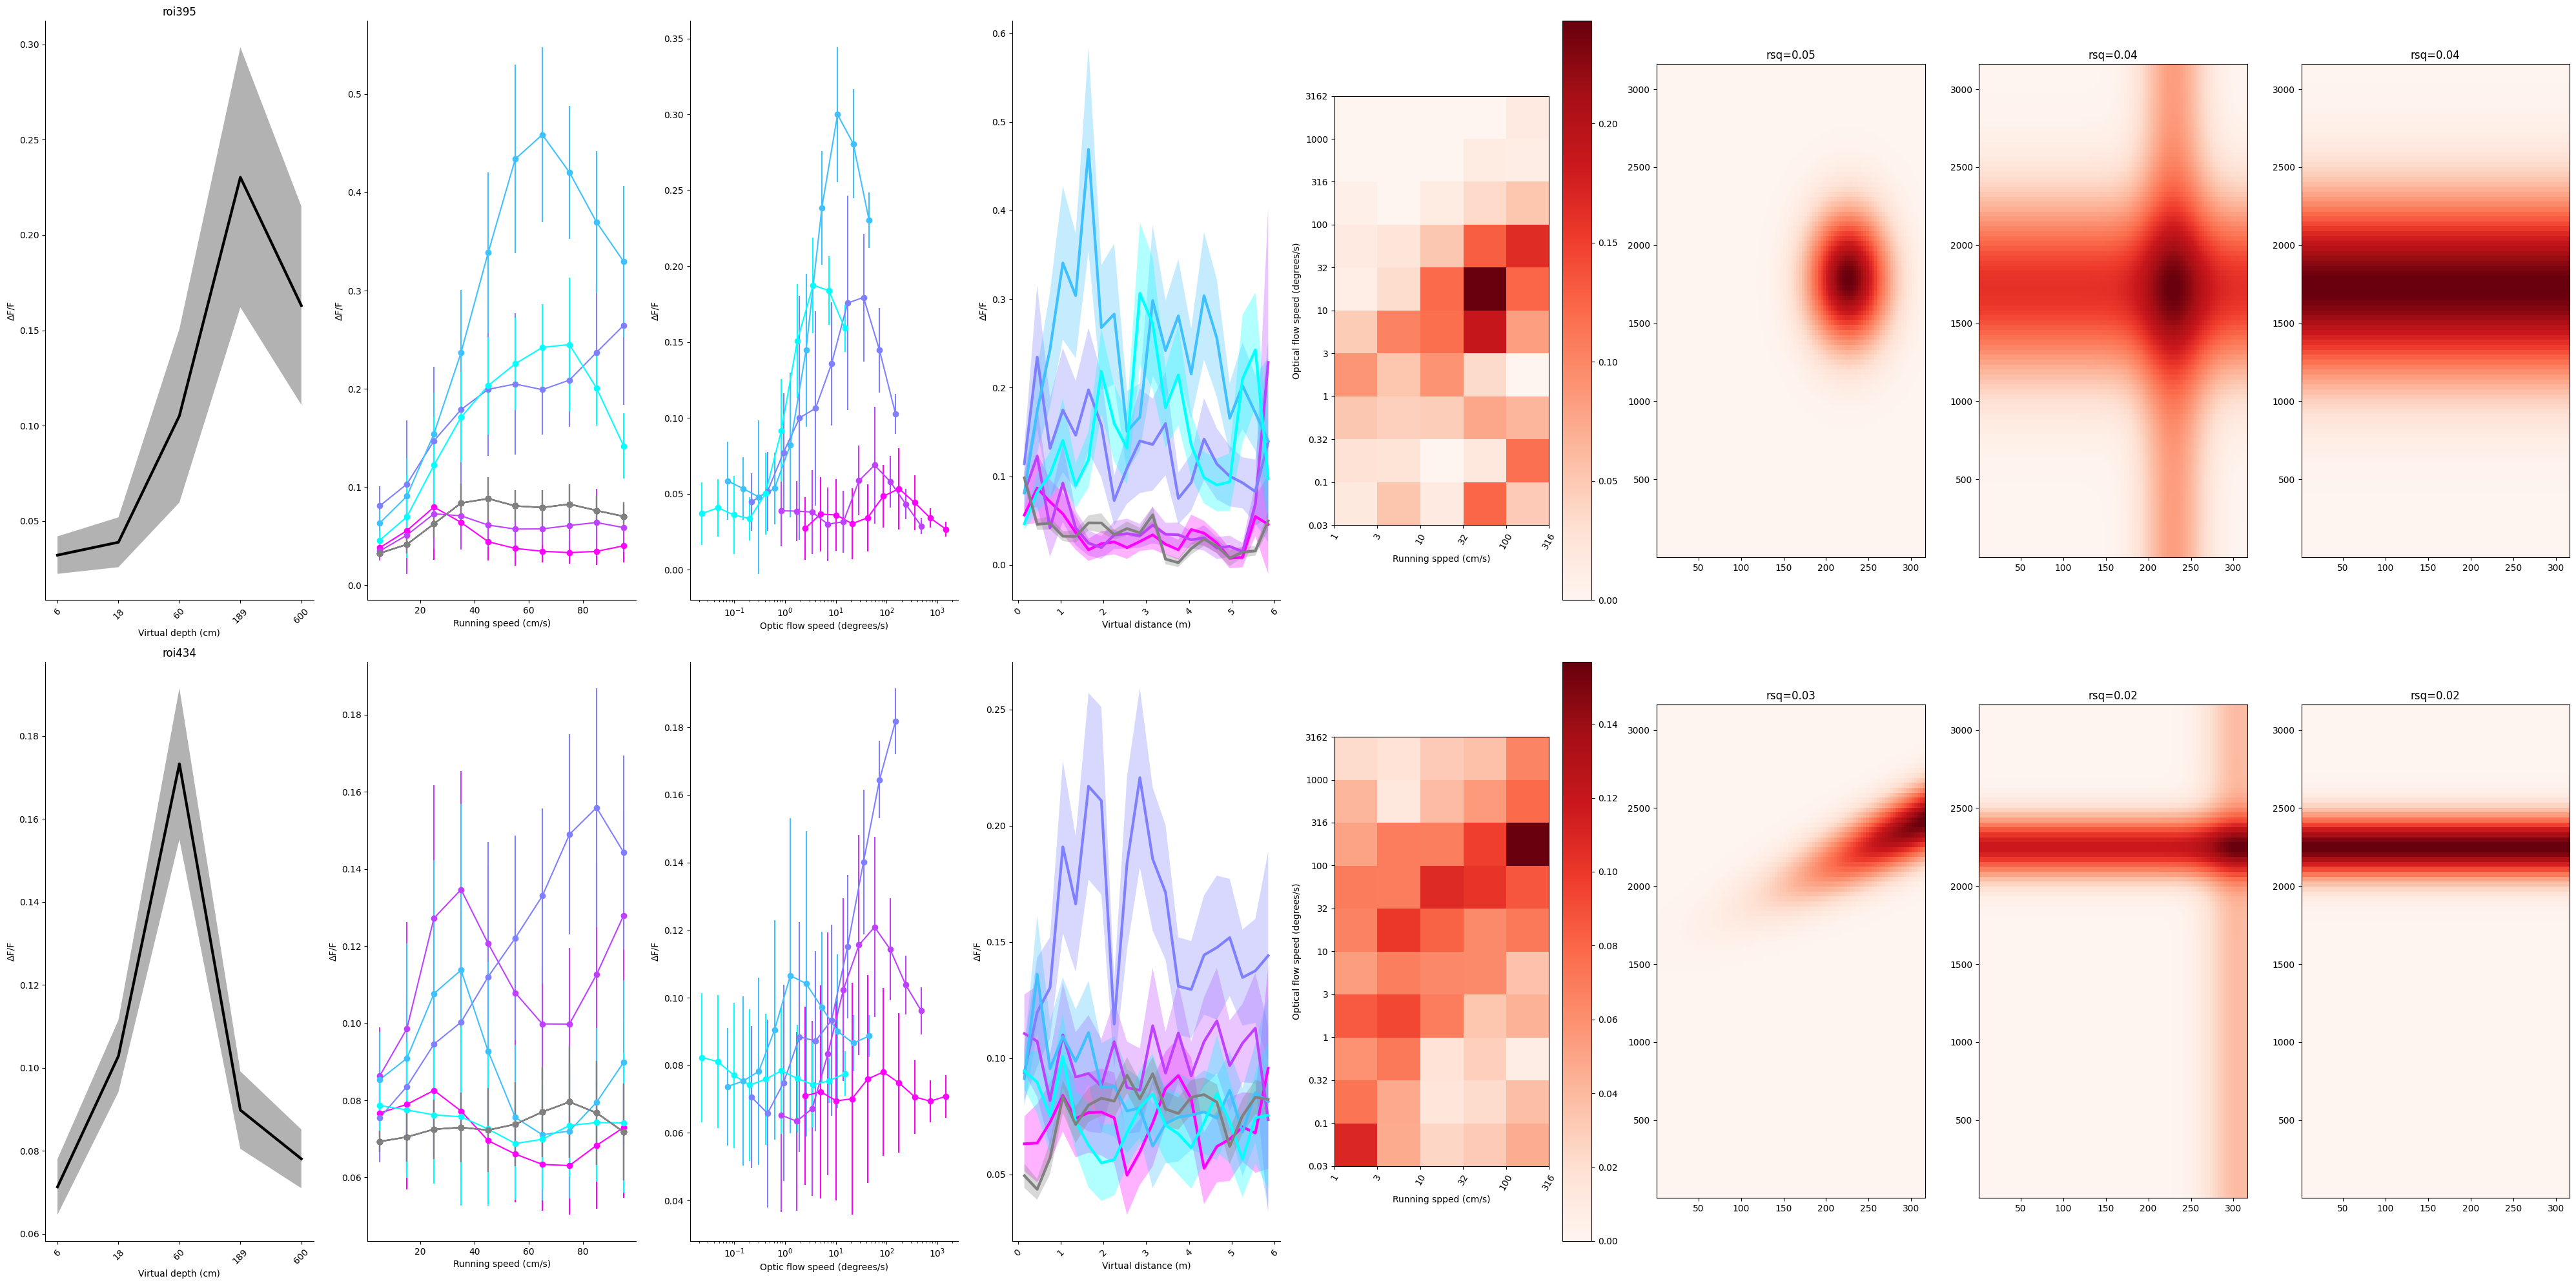

In [4]:
rois = [395, 434]

params = dict(
    rs_thr=0.2,
    rs_curve=dict(speed_min=0.001, speed_max=1, nbins=10, speed_thr=0.001),
)
plt.figure(figsize=(40,20))
plot_rows = len(rois)
plot_cols = 8

for iroi, roi in enumerate(rois):
    plt.subplot2grid((plot_rows, plot_cols), (iroi, 0))
    basic_vis_plots.plot_depth_tuning_curve(
        neurons_df=neurons_df,
        trials_df=trials_df,
        roi=roi,
        rs_thr=params["rs_thr"],
        plot_fit=False,
        linewidth=3,
        linecolor="k",
        fit_linecolor="r",
        closed_loop=1,
    )
    plt.title(f"roi{roi}")

    plt.subplot2grid((plot_rows, plot_cols), (iroi, 1))
    basic_vis_plots.plot_speed_tuning(
        neurons_df=neurons_df,
        trials_df=trials_df,
        roi=roi,
        is_closed_loop=1,
        which_speed="RS",
        smoothing_sd=1,
        **params["rs_curve"],
    )

    plt.subplot2grid((plot_rows, plot_cols), (iroi, 2))
    basic_vis_plots.plot_speed_tuning(
        neurons_df=neurons_df,
        trials_df=trials_df,
        roi=roi,
        is_closed_loop=1,
        nbins=10,
        which_speed="OF",
        speed_min=0.01,
        speed_max=1.5,
        speed_thr=0.01,
        smoothing_sd=1,
    )

    plt.subplot2grid((plot_rows, plot_cols), (iroi, 3))
    basic_vis_plots.plot_PSTH(
        neurons_df=neurons_df,
        trials_df=trials_df,
        roi=roi,
        is_closed_loop=1,
        max_distance=6,
        nbins=20,
        frame_rate=15,
    )
    plt.tight_layout()

    plt.subplot2grid((plot_rows, plot_cols), (iroi, 4))
    log_range = {
        "rs_bin_log_min": 0,
        "rs_bin_log_max": 2.5,
        "rs_bin_num": 6,
        "of_bin_log_min": -1.5,
        "of_bin_log_max": 3.5,
        "of_bin_num": 11,
        "log_base": 10,
    }
    
    basic_vis_plots.plot_RS_OF_matrix(
        trials_df=trials_df,
        roi=roi,
        log_range=log_range,
    )
    
    plt.subplot2grid((plot_rows, plot_cols), (iroi, 5))
    basic_vis_plots.plot_RS_OF_fitted_tuning(
        neurons_df=neurons_df,
        roi=roi,
        model="gaussian_2d",
        min_sigma=0.25,
        log_range={
            "rs_bin_log_min": 0,
            "rs_bin_log_max": 2.5,
            "rs_bin_num": 6,
            "of_bin_log_min": -1.5,
            "of_bin_log_max": 3.5,
            "of_bin_num": 11,
            "log_base": 10,
        },
    )
    plt.title(f"rsq={neurons_df.loc[roi]['rsof_rsq_closedloop_g2d']:.2f}")
    
    plt.subplot2grid((plot_rows, plot_cols), (iroi, 6))
    basic_vis_plots.plot_RS_OF_fitted_tuning(
        neurons_df=neurons_df,
        roi=roi,
        model="gaussian_additive",
        min_sigma=0.25,
        log_range={
            "rs_bin_log_min": 0,
            "rs_bin_log_max": 2.5,
            "rs_bin_num": 6,
            "of_bin_log_min": -1.5,
            "of_bin_log_max": 3.5,
            "of_bin_num": 11,
            "log_base": 10,
        },
    )
    plt.title(f"rsq={neurons_df.loc[roi]['rsof_rsq_closedloop_gadd']:.2f}")  
    
    plt.subplot2grid((plot_rows, plot_cols), (iroi, 7))
    basic_vis_plots.plot_RS_OF_fitted_tuning(
        neurons_df=neurons_df,
        roi=roi,
        model="gaussian_OF",
        min_sigma=0.25,
        log_range={
            "rs_bin_log_min": 0,
            "rs_bin_log_max": 2.5,
            "rs_bin_num": 6,
            "of_bin_log_min": -1.5,
            "of_bin_log_max": 3.5,
            "of_bin_num": 11,
            "log_base": 10,
        },
    )
    plt.title(f"rsq={neurons_df.loc[roi]['rsof_rsq_closedloop_gof']:.2f}")  